In [1]:
%matplotlib inline

/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
import os
import sys
import random
PATH = '/home/ubuntu/music-generation/'
sys.path.append(os.path.join(PATH, 'midi'))

In [3]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as data

In [4]:
import pretty_midi
from midi_utils import midiread, midiwrite
from matplotlib import pyplot as plt
import skimage.io as io
from IPython.display import FileLink

In [5]:
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

In [6]:
ls /home/ubuntu/music-generation/data/avicii/avicii-you_make_me.mid

/home/ubuntu/music-generation/data/avicii/avicii-you_make_me.mid


In [7]:
from pathlib import Path

In [42]:
pth = Path('/home/ubuntu/music-generation/data')

In [43]:
allsongs = list((pth/'calvin_avicii/train').iterdir())

In [44]:
len(allsongs)

48

In [45]:
# shuf -n 10 -e * | xargs -i mv {} path-to-new-folder

In [46]:
midi_data.piano_roll.T.shape

(88, 75)

### DataLoader

In [47]:
import numpy as np
import torch
import torch.utils.data as data


def midi_filename_to_piano_roll(midi_filename):
    
    midi_data = midiread(midi_filename, dt=0.3)
    
    piano_roll = midi_data.piano_roll.T
    
    # Binarize the pressed notes 
    piano_roll[piano_roll > 0] = 1  # no need as unique values are 0 and 1
    
    return piano_roll

In [49]:
def pad_piano_roll(piano_roll, max_length=132333, pad_value=0):
    """
    padding 0 at the beginning of sequence
    
    """
    # We hardcode 88 -- because we will always use only
    # 88 pitches
    
    original_piano_roll_length = piano_roll.shape[1]
    
    padded_piano_roll = np.zeros((88, max_length))
    padded_piano_roll[:] = pad_value
    
    padded_piano_roll[:, :original_piano_roll_length] = piano_roll  # keep 0 padding at begin

    return padded_piano_roll

In [50]:
midi_data.piano_roll.shape

(75, 88)

In [51]:
padded_piano_roll = np.zeros((88,10000))

In [52]:
midi_data.piano_roll.T

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [53]:
padded_piano_roll

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [57]:
class NotesGenerationDataset(data.Dataset):
    
    def __init__(self, midi_folder_path, longest_sequence_length=None):
        
        self.midi_folder_path = midi_folder_path
        
        midi_filenames = os.listdir(midi_folder_path)
        
        self.longest_sequence_length = longest_sequence_length
        
        midi_full_filenames = [os.path.join(midi_folder_path, filename) for filename in midi_filenames]
        
        self.midi_full_filenames = list(midi_full_filenames)
        
        if longest_sequence_length is None:            
            self.update_the_max_length()
    
    
    def update_the_max_length(self):
        """Recomputes the longest sequence constant of the dataset.

        Reads all the midi files from the midi folder and finds the max
        length.
        """
        
        sequences_lengths = [midi_filename_to_piano_roll(filename).shape[1] for filename in self.midi_full_filenames]
        
        max_length = max(sequences_lengths)
        
        self.longest_sequence_length = max_length
                
    
    def __len__(self):
        
        return len(self.midi_full_filenames)
    
    def __getitem__(self, index):
        
        midi_full_filename = self.midi_full_filenames[index]
        
        piano_roll = midi_filename_to_piano_roll(midi_full_filename)
        
        # -1 because we will shift it
        sequence_length = piano_roll.shape[1] - 1
        
        # Shifted by one time step. from previous step, predict the next one
        input_sequence = piano_roll[:, :-1] # skip take the last one
        ground_truth_sequence = piano_roll[:, 1:] # skip the first one
                
        # pad sequence so that all of them have the same lenght
        # Otherwise the batching won't work
        input_sequence_padded = pad_piano_roll(input_sequence, max_length=self.longest_sequence_length)
        
        ground_truth_sequence_padded = pad_piano_roll(ground_truth_sequence,
                                                      max_length=self.longest_sequence_length,
                                                      pad_value=0)
                
        input_sequence_padded = input_sequence_padded.transpose()
        ground_truth_sequence_padded = ground_truth_sequence_padded.transpose()
        
        return (torch.FloatTensor(input_sequence_padded),
                torch.LongTensor(ground_truth_sequence_padded),
                torch.LongTensor([sequence_length]) )

In [58]:
def post_process_sequence_batch(batch_tuple):
    
    input_sequences, output_sequences, lengths = batch_tuple
    
    splitted_input_sequence_batch = input_sequences.split(split_size=1) 
    splitted_output_sequence_batch = output_sequences.split(split_size=1)
    splitted_lengths_batch = lengths.split(split_size=1)

    training_data_tuples = zip(splitted_input_sequence_batch,
                               splitted_output_sequence_batch,
                               splitted_lengths_batch)

    training_data_tuples_sorted = sorted(training_data_tuples,
                                         key=lambda p: int(p[2]),
                                         reverse=True)

    splitted_input_sequence_batch, splitted_output_sequence_batch, splitted_lengths_batch = zip(*training_data_tuples_sorted)

    input_sequence_batch_sorted = torch.cat(splitted_input_sequence_batch)
    output_sequence_batch_sorted = torch.cat(splitted_output_sequence_batch)
    lengths_batch_sorted = torch.cat(splitted_lengths_batch)
    
    # Here we trim overall data matrix using the size of the longest sequence
    input_sequence_batch_sorted = input_sequence_batch_sorted[:, :lengths_batch_sorted[0, 0], :]
    output_sequence_batch_sorted = output_sequence_batch_sorted[:, :lengths_batch_sorted[0, 0], :]
    
    input_sequence_batch_transposed = input_sequence_batch_sorted.transpose(0, 1)
    
    # pytorch's api for rnns wants lenghts to be list of ints
    lengths_batch_sorted_list = list(lengths_batch_sorted)
    lengths_batch_sorted_list = map(lambda x: int(x), lengths_batch_sorted_list)
    
    return input_sequence_batch_transposed, output_sequence_batch_sorted, list(lengths_batch_sorted_list)

In [60]:
trainset = NotesGenerationDataset(os.path.join(PATH, 'data/calvin_avicii/train/'), longest_sequence_length=None)

trainset_loader = data.DataLoader(trainset, batch_size=5,
                                              shuffle=True, num_workers=4, drop_last=True)

In [61]:
X = next(iter(trainset_loader))

In [62]:
input_sequences = X[0]

In [63]:
X[0].shape

torch.Size([5, 1200, 88])

In [64]:
X[1].shape

torch.Size([5, 1200, 88])

In [65]:
X[0][:3]


( 0  ,.,.) = 
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
     ...       ⋱       ...    
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0

( 1  ,.,.) = 
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
     ...       ⋱       ...    
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0

( 2  ,.,.) = 
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
     ...       ⋱       ...    
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
[torch.FloatTensor of size 3x1200x88]

In [66]:
X[1][:3]


( 0  ,.,.) = 
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
     ...       ⋱       ...    
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0

( 1  ,.,.) = 
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
     ...       ⋱       ...    
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0

( 2  ,.,.) = 
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
     ...       ⋱       ...    
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
[torch.LongTensor of size 3x1200x88]

In [67]:
X[2][:5] # sequence length


 25
 20
 53
 24
 50
[torch.LongTensor of size 5x1]

In [68]:
torch.sum(X[0])

486.0

In [70]:
valset = NotesGenerationDataset(os.path.join(PATH, 'data/calvin_avicii//valid/'), longest_sequence_length=None)

valset_loader = data.DataLoader(valset, batch_size=5, shuffle=False, num_workers=4, drop_last=False)

In [71]:
X_val = next(iter(valset_loader))

In [72]:
X_val[0].shape

torch.Size([5, 859, 88])

In [73]:
torch.sum(X_val[0])

631.0

In [74]:
splitted_input_sequence_batch = X[0].split(split_size=1) 

In [75]:
splitted_input_sequence_batch

(
 ( 0  ,.,.) = 
    0   0   0  ...    0   0   0
    0   0   0  ...    0   0   0
    0   0   0  ...    0   0   0
      ...       ⋱       ...    
    0   0   0  ...    0   0   0
    0   0   0  ...    0   0   0
    0   0   0  ...    0   0   0
 [torch.FloatTensor of size 1x1200x88], 
 ( 0  ,.,.) = 
    0   0   0  ...    0   0   0
    0   0   0  ...    0   0   0
    0   0   0  ...    0   0   0
      ...       ⋱       ...    
    0   0   0  ...    0   0   0
    0   0   0  ...    0   0   0
    0   0   0  ...    0   0   0
 [torch.FloatTensor of size 1x1200x88], 
 ( 0  ,.,.) = 
    0   0   0  ...    0   0   0
    0   0   0  ...    0   0   0
    0   0   0  ...    0   0   0
      ...       ⋱       ...    
    0   0   0  ...    0   0   0
    0   0   0  ...    0   0   0
    0   0   0  ...    0   0   0
 [torch.FloatTensor of size 1x1200x88], 
 ( 0  ,.,.) = 
    0   0   0  ...    0   0   0
    0   0   0  ...    0   0   0
    0   0   0  ...    0   0   0
      ...       ⋱       ...    
    0   0   0  

### RNN

In [76]:
class RNN(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_classes, n_layers=2):
        
        super(RNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.n_layers = n_layers
        
        self.notes_encoder = nn.Linear(in_features=input_size, out_features=hidden_size)
        
        self.bn = nn.BatchNorm1d(hidden_size)
        
        self.lstm = nn.LSTM(hidden_size, hidden_size, n_layers)
        
        self.logits_fc = nn.Linear(hidden_size, num_classes)
    
    
    def forward(self, input_sequences, input_sequences_lengths, hidden=None):
        batch_size = input_sequences.shape[1]

        notes_encoded = self.notes_encoder(input_sequences)
        notes_encoded_rolled = notes_encoded.permute(1,2,0).contiguous()
        notes_encoded_norm = self.bn(notes_encoded_rolled)
        notes_encoded_norm_drop = nn.Dropout(0.25)(notes_encoded_norm)
        notes_encoded_complete = notes_encoded_norm_drop.permute(2,0,1)
        
        # Here we run rnns only on non-padded regions of the batch
        packed = torch.nn.utils.rnn.pack_padded_sequence(notes_encoded_complete, input_sequences_lengths)
        outputs, hidden = self.lstm(packed, hidden)
        outputs, output_lengths = torch.nn.utils.rnn.pad_packed_sequence(outputs) # unpack (back to padded)
        
        outputs_norm = self.bn(outputs.permute(1,2,0).contiguous())
        outputs_drop = nn.Dropout(0.1)(outputs_norm)
        logits = self.logits_fc(outputs_drop.permute(2,0,1))
        logits = logits.transpose(0, 1).contiguous()
        
        neg_logits = (1 - logits)
        
        # Since the BCE loss doesn't support masking, we use the crossentropy
        binary_logits = torch.stack((logits, neg_logits), dim=3).contiguous()
        logits_flatten = binary_logits.view(-1, 2)
        return logits_flatten, hidden

In [86]:
def validate(model):
    model.eval()
    full_val_loss = 0.0
    overall_sequence_length = 0.0

    for batch in valset_loader:

        post_processed_batch_tuple = post_process_sequence_batch(batch)

        input_sequences_batch, output_sequences_batch, sequences_lengths = post_processed_batch_tuple

        output_sequences_batch_var =  Variable( output_sequences_batch.contiguous().view(-1).cuda() )

        input_sequences_batch_var = Variable( input_sequences_batch.cuda() )

        logits, _ = model(input_sequences_batch_var, sequences_lengths)

        loss = criterion_val(logits, output_sequences_batch_var)

        full_val_loss += loss.data[0]
        overall_sequence_length += sum(sequences_lengths)

    return full_val_loss / (overall_sequence_length * 88)

In [81]:
len(trainset_loader)

9

In [82]:
model = RNN(input_size=88, hidden_size=512, num_classes=88).cuda()

criterion = nn.CrossEntropyLoss().cuda()
criterion_val = nn.CrossEntropyLoss(size_average=False).cuda()

In [87]:
# initial model loss without training
validate(model)

3.6014622066494075

In [118]:
clip = 1.0
epochs_number = 10
sample_history = []
best_val_loss = float("inf")

In [90]:
def lrfinder(start, end, model, trainset_loader, epochs=20):
    model.train() # into training mode
    lrs = np.linspace(start, end, epochs*len(trainset_loader))
    parameters = filter(lambda p: p.requires_grad, model.parameters()) # get all parameters which need grad
    optimizer = torch.optim.Adam(rnn.parameters(),start)
    loss_list = []
    ctr = 0
    
    for epoch_number in range(epochs):
        epoch_loss = []
        for batch in trainset_loader:
            optimizer.param_groups[0]['lr'] = lrs[ctr]
            ctr = ctr+1

            post_processed_batch_tuple = post_process_sequence_batch(batch)

            input_sequences_batch, output_sequences_batch, sequences_lengths = post_processed_batch_tuple

            output_sequences_batch_var =  Variable( output_sequences_batch.contiguous().view(-1).cuda() )

            input_sequences_batch_var = Variable( input_sequences_batch.cuda() )

            optimizer.zero_grad()

            logits, _ = model(input_sequences_batch_var, sequences_lengths)

            loss = criterion(logits, output_sequences_batch_var)
            loss_list.append(loss.data[0])
            loss.backward()

            torch.nn.utils.clip_grad_norm(rnn.parameters(), clip)

            optimizer.step()
        if epocprint('Epoch %d' % epoch_number)
    plt.plot(lrs, loss_list)
    return lrs, loss_list

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49


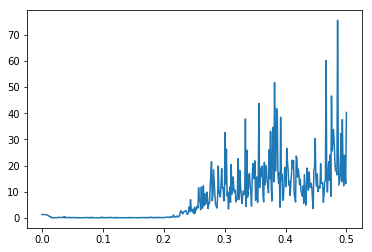

In [93]:
rnn = RNN(input_size=88, hidden_size=512, num_classes=88)
rnn = rnn.cuda()
lrs, losses = lrfinder(1e-4, 1e-1*5, rnn, trainset_loader, epochs=50)

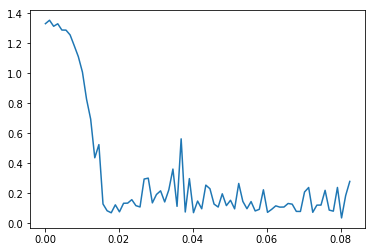

In [97]:
plt.plot(lrs[:75], losses[:75])

Training

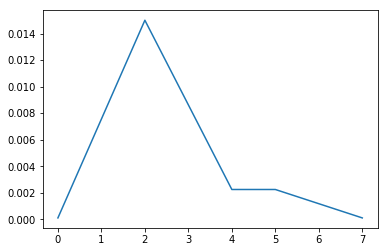

In [112]:
def get_triangular_lr(lr_low, lr_high, mini_batches, epochs_number = 1):
    iterations = mini_batches*epochs_number
    lr_mid = lr_high/7 + lr_low
    up = np.linspace(lr_low, lr_high, int(round(iterations*0.35)))
    down = np.linspace(lr_high, lr_mid, int(round(iterations*0.35)))
    floor = np.linspace(lr_mid, lr_low, int(round(iterations*0.30)))
    return np.hstack([up, down[1:], floor])

lrs_triangular = get_triangular_lr(1e-4, 1e-2*1.5, len(trainset_loader))
plt.plot(lrs_triangular)

In [113]:
len(lrs_triangular)

8

In [127]:
def train_model(model, lrs_triangular, epochs_number=10, wd=0.0, best_val_loss=float("inf")):
    loss_list = []
    val_list =[]
    optimizer = torch.optim.Adam(rnn.parameters(), lr=lrs_triangular[0], weight_decay=wd)
    ctr = 0
    
    for epoch_number in range(epochs_number):
        model.train()
        epoch_loss = []
        for batch in trainset_loader:
            print(ctr)
            try: 
                optimizer.param_groups[0]['lr'] = lrs_triangular[ctr]
            except IndexError: pass
            ctr+=1

            post_processed_batch_tuple = post_process_sequence_batch(batch)

            input_sequences_batch, output_sequences_batch, sequences_lengths = post_processed_batch_tuple

            output_sequences_batch_var =  Variable( output_sequences_batch.contiguous().view(-1).cuda() )

            input_sequences_batch_var = Variable( input_sequences_batch.cuda() )

            optimizer.zero_grad()

            logits, _ = model(input_sequences_batch_var, sequences_lengths)

            loss = criterion(logits, output_sequences_batch_var)
            loss_list.append(loss.data[0])
            epoch_loss.append(loss.data[0])
            loss.backward()

            torch.nn.utils.clip_grad_norm(model.parameters(), clip)

            optimizer.step()

        current_trn_epoch = sum(epoch_loss)/len(trainset_loader)
        print('Training Loss: Epoch:',epoch_number,':', current_trn_epoch)

        current_val_loss = validate(model)
        print('Validation Loss: Epoch:',epoch_number,':', current_val_loss)
        print('')

        val_list.append(current_val_loss)

        if current_val_loss < best_val_loss:

            torch.save(model.state_dict(), 'music_calvin_avicii.pth')
            best_val_loss = current_val_loss
    return best_val_loss

In [123]:
rnn = RNN(input_size=88, hidden_size=512, num_classes=88)
rnn = rnn.cuda()
lrs_triangular = get_triangular_lr(1e-4, 1e-2*1.5, len(trainset_loader),epochs_number=5)
best_val_loss = train_model(rnn, lrs_triangular, epochs_number=5)

Training Loss: Epoch: 0 : 1.2760571373833551
Validation Loss: Epoch: 0 : 2.791318721102696

Training Loss: Epoch: 1 : 0.44021213261617553
Validation Loss: Epoch: 1 : 0.32801374216927154

Training Loss: Epoch: 2 : 0.1406464787820975
Validation Loss: Epoch: 2 : 0.4947714238938565

Training Loss: Epoch: 3 : 0.09272268248928918
Validation Loss: Epoch: 3 : 0.7893566836004777

Training Loss: Epoch: 4 : 0.08262002592285474
Validation Loss: Epoch: 4 : 0.7290951635109193



In [128]:
lrs_triangular = get_triangular_lr(1e-4, 1e-2, len(trainset_loader),epochs_number=20)
best_val_loss = train_model(rnn, lrs_triangular, epochs_number=20, wd=1e-3)

0
1
2
3
4
5
6
7
8
Training Loss: Epoch: 0 : 0.06575368055038983
Validation Loss: Epoch: 0 : 0.1990716993955795

9
10
11
12
13
14
15
16
17
Training Loss: Epoch: 1 : 0.07577508522404565
Validation Loss: Epoch: 1 : 0.3201824586517855

18
19
20
21
22
23
24
25
26
Training Loss: Epoch: 2 : 0.0702356683711211
Validation Loss: Epoch: 2 : 0.405188847569199

27
28
29
30
31
32
33
34
35
Training Loss: Epoch: 3 : 0.08062900106112163
Validation Loss: Epoch: 3 : 0.23767517285879022

36
37
38
39
40
41
42
43
44
Training Loss: Epoch: 4 : 0.08308237625492944
Validation Loss: Epoch: 4 : 0.26765861275064784

45
46
47
48
49
50
51
52
53
Training Loss: Epoch: 5 : 0.07542858148614566
Validation Loss: Epoch: 5 : 0.2238693091698778

54
55
56
57
58
59
60
61
62
Training Loss: Epoch: 6 : 0.08401630529099041
Validation Loss: Epoch: 6 : 0.221961715137837

63
64
65
66
67
68
69
70
71
Training Loss: Epoch: 7 : 0.09696483756932947
Validation Loss: Epoch: 7 : 0.24696987709486135

72
73
74
75
76
77
78
79
80
Training Loss: 

In [129]:
best_val_loss

0.1990716993955795

In [130]:
rnn.load_state_dict(torch.load('music_calvin_avicii.pth'))

### Validation

In [131]:
current_sequence_input = torch.zeros(1, 1, 88)
current_sequence_input[0, 0, 40] = 1
current_sequence_input[0, 0, 50] = 0
current_sequence_input[0, 0, 56] = 0
current_sequence_input = Variable(current_sequence_input.cuda())

In [175]:
current_sequence_input.data.squeeze(1)



Columns 0 to 12 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 13 to 25 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 26 to 38 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 39 to 51 
    0     1     0     0     0     0     0     0     0     0     0     0     0

Columns 52 to 64 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 65 to 77 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 78 to 87 
    0     0     0     0     0     0     0     0     0     0
[torch.cuda.FloatTensor of size 1x88 (GPU 0)]

In [136]:
def sample_from_piano_rnn(sample_length=4, temperature=1, starting_sequence=None):

    if starting_sequence is None:
                
        current_sequence_input = torch.zeros(1, 1, 88)
        current_sequence_input[0, 0, 40] = 1
        current_sequence_input[0, 0, 50] = 0
        current_sequence_input[0, 0, 56] = 0
        current_sequence_input = Variable(current_sequence_input.cuda())

    
    else:
        current_sequence_input = Variable(starting_sequence)
    final_output_sequence = [current_sequence_input.data.squeeze(1)]
    
    hidden = None    

    for i in range(sample_length):

        output, hidden = rnn(current_sequence_input, [1], hidden)

        probabilities = nn.functional.softmax(output.div(temperature), dim=1)

        current_sequence_input = torch.multinomial(probabilities.data, 1).squeeze().unsqueeze(0).unsqueeze(1)

        current_sequence_input = Variable(current_sequence_input.float())

        final_output_sequence.append(current_sequence_input.data.squeeze(1))

    sampled_sequence = torch.cat(final_output_sequence, dim=0).cpu().numpy()
    
    return sampled_sequence

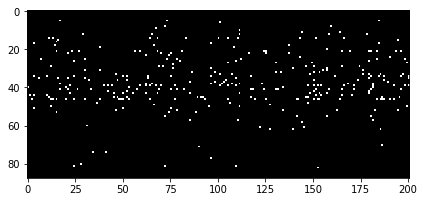

In [171]:
sample = sample_from_piano_rnn(sample_length=200, temperature=0.7).transpose()
io.imshow(sample)

In [172]:
midiwrite('sample.mid', sample.transpose(), dt=0.3)

In [173]:
FileLink('sample.mid')

/home/ubuntu/music-generation/sample.mid

Testloader

In [211]:
testset = NotesGenerationDataset('data/calvin_avicii/valid/', longest_sequence_length=None)

testset_loader = torch.utils.data.DataLoader(testset, batch_size=1, 
                                            shuffle=True, num_workers=4, drop_last=False)

In [234]:
batch = next(iter(testset_loader))
post_processed_batch_tuple = post_process_sequence_batch(batch)

input_sequences_batch, output_sequences_batch, sequences_lengths = post_processed_batch_tuple

output_sequences_batch_var =  output_sequences_batch.contiguous().view(-1).cuda()

input_sequences_batch_var = input_sequences_batch.cuda()

In [235]:
sample_orig = batch[0].numpy()

In [236]:
sample_orig.shape

(1, 859, 88)

In [237]:
sample_orig = sample_orig.reshape((sample_orig.shape[1], sample_orig.shape[2]))

In [238]:
midiwrite('test0_orig.mid', sample_orig, dt=0.3)

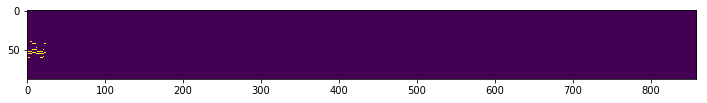

In [239]:
fig, ax = plt.subplots(figsize=(12,10))
ax.imshow(sample_orig.transpose())

In [240]:
FileLink('test0_orig.mid')

/home/ubuntu/music-generation/test0_orig.mid

In [241]:
input_sequences_batch_var.shape

torch.Size([25, 1, 88])

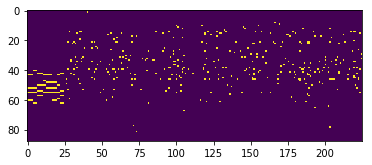

In [242]:
sample = sample_from_piano_rnn(sample_length=200, temperature=0.7, 
                               starting_sequence=input_sequences_batch_var).transpose()
plt.imshow(sample)

In [243]:
sample.shape

(88, 225)

In [244]:
midiwrite('test0.mid', sample.transpose(), dt=0.3)

In [245]:
FileLink('test0.mid')

/home/ubuntu/music-generation/test0.mid